# Create WecOptTool Model for the Marson WEC concept

In [8]:
import numpy as np
import capytaine as cpt
from capytaine.io.meshio import load_from_meshio
import matplotlib.pyplot as plt
from scipy.optimize import brute
import pygmsh
import os
import xarray as xr
import capytaine.io.mesh_writers

## set colorblind-friendly colormap for plots
plt.style.use('tableau-colorblind10')

import logging
logging.getLogger().setLevel(logging.INFO)

In [9]:
# set frequencies
wCapy =  np.linspace(0.04, 10.0, 100)                  # wave frequencies - also used to specify the lid position

-0.0914539114058809


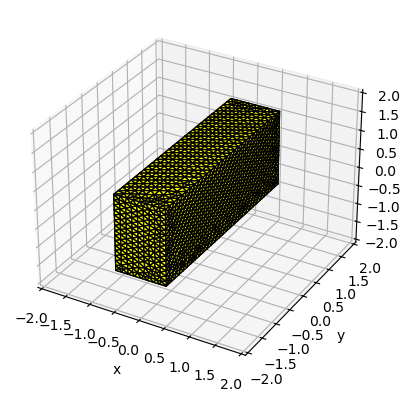

In [10]:
## Input parameters for geometry
numBodies = 1
bodyDist = 0 # distanc between each body's cg
bodyLocs = [-0.5*bodyDist, -1.5*bodyDist] # assumes bodies are connected to stationary PTO at x=0
mesh_size_factor = 0.14 # works well for this size 
depth = 2
bodDraft = [1, 1]#, 1]
bodWidth = [1, 1]#, 1]
bodLength = [2, 2]#, 2]

hydrostaticsDict = {}
rect = {}
bodList = [] 

for nBod in range(numBodies):
    with pygmsh.geo.Geometry() as geom:
        poly1 = geom.add_polygon(
            [[bodyLocs[nBod]-bodWidth[nBod]/2, bodLength[nBod]],
            [bodyLocs[nBod]-bodWidth[nBod]/2,-bodLength[nBod]],
            [bodyLocs[nBod]+bodWidth[nBod]/2,-bodLength[nBod]],
            [bodyLocs[nBod]+bodWidth[nBod]/2,bodLength[nBod]]],mesh_size=mesh_size_factor)
        
        geom.translate(poly1, [0, 0, depth-bodDraft[nBod]])
        geom.extrude(poly1,[0,0,-depth])
        rectMesh = geom.generate_mesh()
        meshObj = load_from_meshio(rectMesh, 'Rect')
        lid_pos = meshObj.lowest_lid_position(max(wCapy)) # add lid to reduce irregular frequency peaks
        print(lid_pos)
        lidMesh = meshObj.generate_lid(z=lid_pos)

        # define the floating body
        rect[nBod] = cpt.FloatingBody(mesh=rectMesh, lid_mesh = lidMesh, name="rect"+str(nBod), center_of_mass=(bodyLocs[nBod], 0, 0))
        #rect[nBod].keep_immersed_part()
        rect[nBod].rotation_center = rect[nBod].center_of_mass
        rect[nBod].add_all_rigid_body_dofs()

        bodList.append(rect[nBod])

all_bodies = cpt.FloatingBody.join_bodies(*bodList)

all_bodies.show_matplotlib()

#all_bodies.show()

# Export them to STL
mesh = bodList[0].mesh

# save as gdf using meshmagick
capytaine.io.mesh_writers.write_STL('float.stl', mesh.vertices, mesh.faces)
